# Modeling Stock Movements as Geometric Brownian Motion

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In [1]:
#package import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Stock paths as limits of binomial trees

Let $t\in \mathbb{Q}_{>0}$ and $S(t)$ the distribution of stock paths from time $t=0$ to time $t$ (measured in years).

Assume the following:
 - For each $n\in\mathbb{N}$ so that $tn\in\mathbb{N}$, there is an $nt$ binomial tree path $S_n(t)$ so that $\lim_{n\to\infty}S_n(t) = S(t)$ with the following additional properties:
  - There exists $E[S_n(t)-S(0)] = E[S(t)-S(0)]$;
  - There exists $\sigma$ so that $Var(S_n(t)) = \sigma t$ for all $n$;
  - Each step in the random walk of $S_n(t)$ has equal probability of going up or down.
Then $$\displaystyle S(t) = S(0)e^{\mu t -\frac{\sigma^2}{2}t + \sigma \sqrt{t}\mathcal{N}(0,1)}$$
where
  - $\mu$ is the yearly drift rate of log-returns;
  - $\sigma$ is the yearly standard deviation (volatility) of log-returns;
  - $\mathcal{N}(0,1)$ is the standard normal distribution.
  
#### Geomtric Brownian Motion:
The distribution described by the limit of binomial trees is a type of Geometric Brownian Motion.
  
#### Remark: 
If $t$ is not necessarily rational, we can still use the same forumla $S(t) = S(0)e^{\mu t -\frac{\sigma^2}{2}t + \sigma \sqrt{t}\mathcal{N}(0,1)}$ as the distribution of stock paths.


#### Discounted Rates:
If $r$ is the continuously compounded discounted rate of the current value of money, then the current return value of the stock distribution has distribution
$$\displaystyle S(t) = S(0)e^{\mu t -\frac{\sigma^2}{2}t - rt + \sigma \sqrt{t}\mathcal{N}(0,1)} = S(0)e^{\left(\mu -r -\frac{\sigma^2}{2}\right)t + \sigma\sqrt{t}\mathcal{N}(0,1)}.$$
  

In [2]:
# Write a function that models a stock movement as a geometric brownian motion
def geo_path_stock(S0, sigma, mu = 0, n = 1, t = 1, r = 0):
    """
    Description:
    
        Models a stock movement with volatility sigma measured as the yearly standard deviation of log returns
    
    Parameters:

        S0 -- Initial stock price

        mu -- Mean/drift term

        sigma -- Standard deviation of log returns over 252 trading days

        n -- Number of steps simulate
        
        t -- Time measured in yearly trading days ~ 252.
        
        r -- Continuously compounded interest rate.
        
        Remark: One month of trading days ~ 21. So to simulate one month of a stock movement set t = 21/252 = 1/12.

    Returns: 
        numpy array
    """
    
    dt = t/n
    
    N = np.random.normal(0,1, size = n)
    
    increments = (mu - r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*N
    
    log_returns = np.cumsum(increments)
    
    path = np.empty(n+1)
    
    path[0] = S0
    
    path[1:] = S0*np.exp(log_returns)
    
    return path

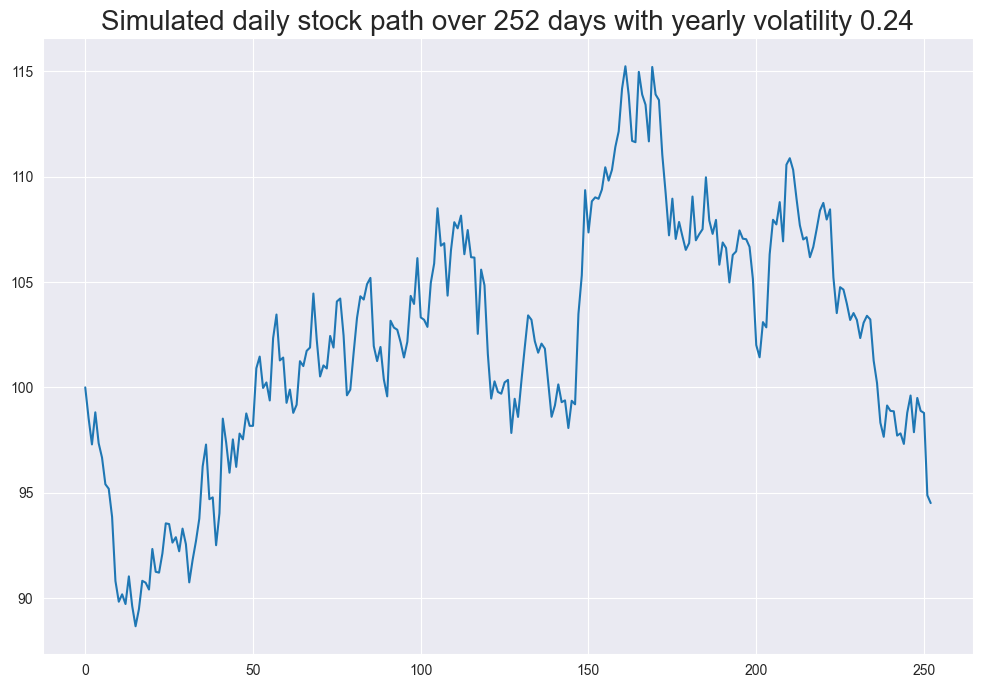

In [5]:
# Demonstrate geo_path_stock
S0 = 100
sigma = .24
steps = 252
# t = 1

stock_path = geo_path_stock(S0, sigma, n =steps)


plt.figure(figsize = (12,8))
plt.plot(stock_path)
plt.title(f'Simulated daily stock path over {steps} days with yearly volatility {sigma}', size = 20)
plt.show()

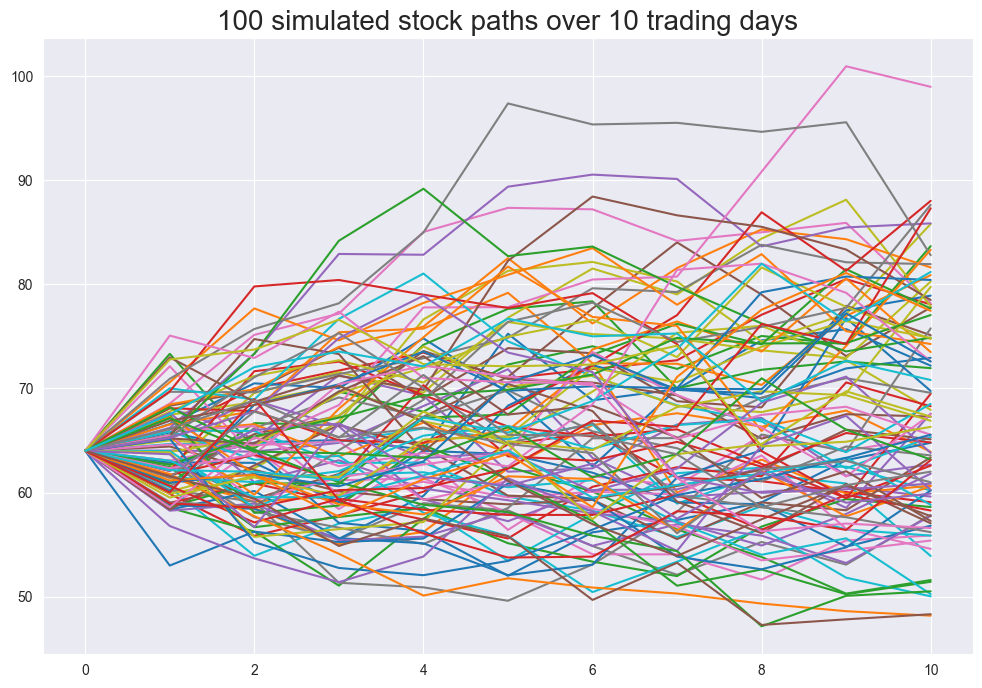

In [8]:
#simulate and plot 100 10 step daily stock paths.
S0 = 64
sigma = .2
steps = 10
num_paths = 100


stock_paths = [geo_path_stock(S0, sigma, mu = .05, n = steps) for _ in range(num_paths)]


plt.figure(figsize = (12,8))
plt.title(f'{num_paths} simulated stock paths over 10 trading days', size = 20)
for path in stock_paths:
    plt.plot(path)
plt.show()

### Common practice

It is common practice to model a stock or index volatility by looking at historical volatility. This can be especially valuable if historical stock/index log-returns are normally distributed.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


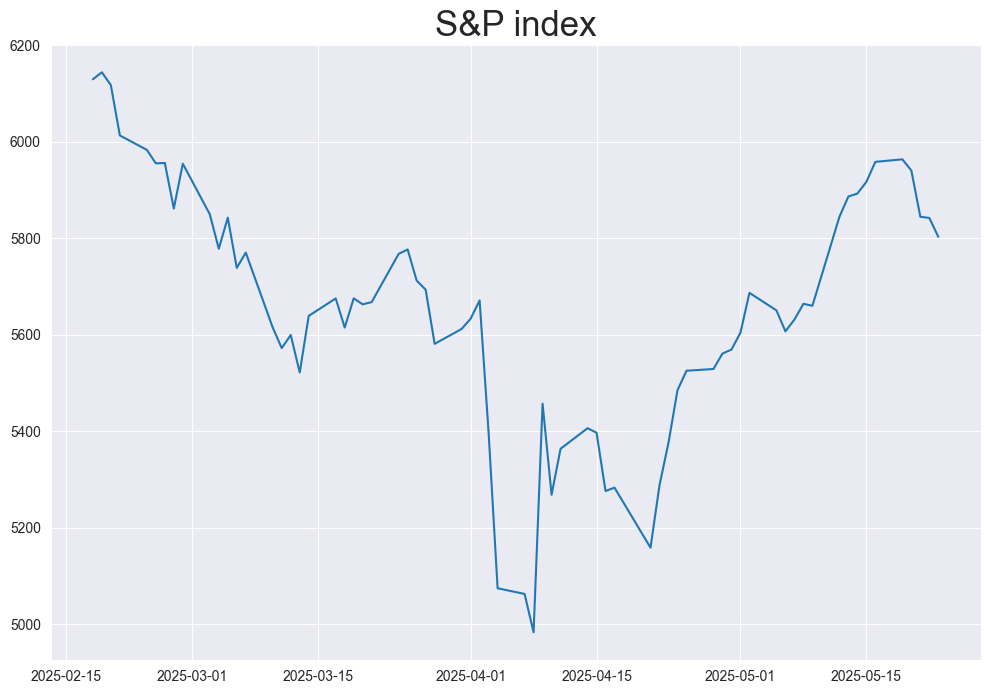

In [9]:
#Download historical S&P500 data
start_date = dt.datetime.today() - dt.timedelta(days = 100)
end_date = dt.datetime.today()
SP_data = yf.download('^GSPC', start = start_date, end = end_date) #yfinance symbol for S&P500


plt.figure(figsize = (12,8))
plt.plot(SP_data['Close'])
plt.title('S&P index', size = 25)
plt.show()

In [10]:
# Use historical data to estimate std deviation of log returns
SP_log_returns = np.log(SP_data['Close']/SP_data['Close'].shift(1))
SP_log_returns = SP_log_returns.dropna()
SP_log_returns_values = SP_log_returns.values

sigma = np.std(SP_log_returns_values)*np.sqrt(252)



#Set starting value of simulated stocks to be last closing price of S&P

S0 = SP_data['Close'].iloc[-1].iloc[-1]

In [11]:
sigma, S0

(0.3078096374968569, 5802.81982421875)

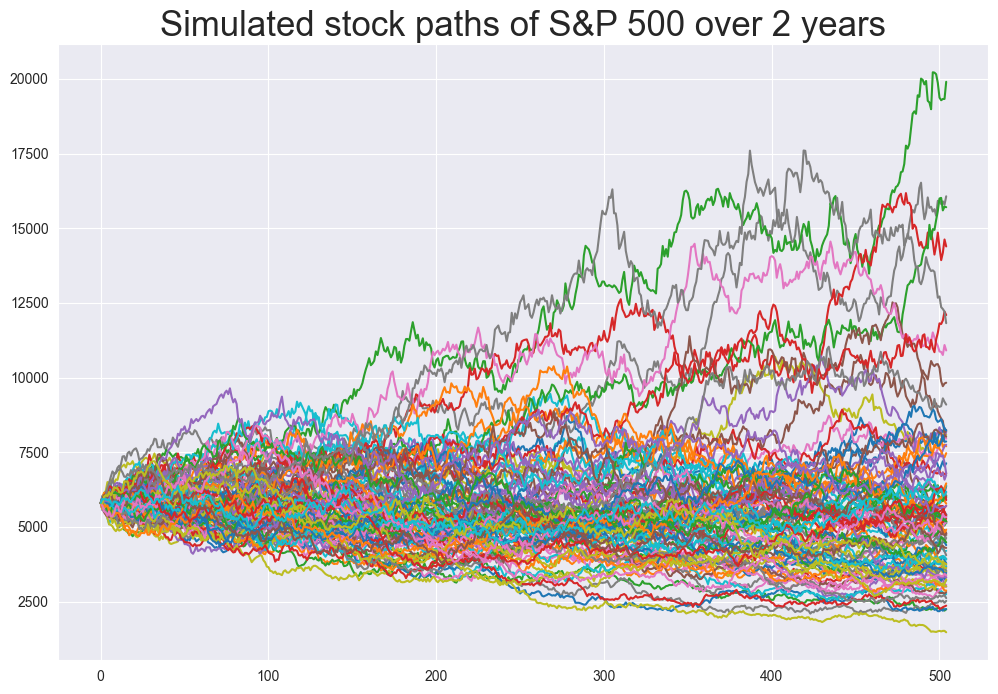

In [12]:
#Simulate and plot 100 daily stock paths over 2 years
SP_paths = [geo_path_stock(S0,sigma, n = 252*2, t = 2) for _ in range(100)]

plt.figure(figsize = (12,8))
for SP_path in SP_paths:
    plt.plot(SP_path)
plt.title('Simulated stock paths of S&P 500 over 2 years', size = 25)
plt.show()

### Time Saving Remark
When modeling stock paths via a geometric brownian motion, or any other model, if we only care about estimating the final value over a future trading period, we do not have to simulate individual steps.

In [14]:
#Simulate daily step paths
SP_paths = [geo_path_stock(S0, sigma, n = 2*252, t = 2) for _ in range(100000)]

In [15]:
#Examine lengths of SP_paths and a path in SP_paths
len(SP_paths), len(SP_paths[0])

(100000, 505)

In [16]:
#Find mean value of end points of stock paths in SP_paths
np.mean([path[-1] for path in SP_paths])

5801.207945617609

In [17]:
#Simulate 1 step stock paths
SP_paths_one_step = [geo_path_stock(S0, sigma, n = 1, t = 2) for _ in range(100000)]

In [18]:
#Examine lengths of SP_paths_one_step and a path in SP_paths_one_step
len(SP_paths_one_step), len(SP_paths_one_step[0])

(100000, 2)

In [19]:
#Find mean value of end points of stock paths in SP_paths_one_step
np.mean([path[-1] for path in SP_paths_one_step])

5804.003465944474